In [1]:
import os
os.chdir(r"C:\Users\gram\Desktop\prj 1\data13")

import numpy as np #데이터 처리
import pandas as pd #데이터 처리
import warnings
warnings.filterwarnings('ignore')
from collections import Counter # count 용도

import matplotlib.pyplot as plt # 시각화
import seaborn as sns #시각화

import folium # 지도 관련 시각화
from folium.plugins import MarkerCluster #지도 관련 시각화
import geopy.distance #거리 계산해주는 패키지 사용

import random #데이터 샘플링
from sklearn.model_selection import GridSearchCV #모델링
from sklearn.ensemble import RandomForestRegressor #모델링

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train['date2'] = pd.to_datetime(train['date'])

In [4]:
train['weekday'] = train['date2'].dt.weekday

In [5]:
train = pd.get_dummies(train,columns=['weekday'])

In [6]:
test['date2'] = pd.to_datetime(test['date'])
test['weekday'] = test['date2'].dt.weekday
test = pd.get_dummies(test,columns=['weekday'])

In [7]:
del train['date2']
del test['date2']

In [8]:
train['in_out'].value_counts()

시내    408500
시외      6923
Name: in_out, dtype: int64

In [9]:
train['in_out'] = train['in_out'].map({'시내':0,'시외':1})

In [10]:
test['in_out'] = test['in_out'].map({'시내':0,'시외':1})

In [11]:
train['68a']=train['6~7_ride']+train['7~8_ride'] # 6 ~ 8시 승차인원
train['810a']=train['8~9_ride']+train['9~10_ride']
train['1012a']=train['10~11_ride']+train['11~12_ride']

train['68b']=train['6~7_takeoff']+train['7~8_takeoff'] # 6 ~ 8시 하차인원
train['810b']=train['8~9_takeoff']+train['9~10_takeoff']
train['1012b']=train['10~11_takeoff']+train['11~12_takeoff']

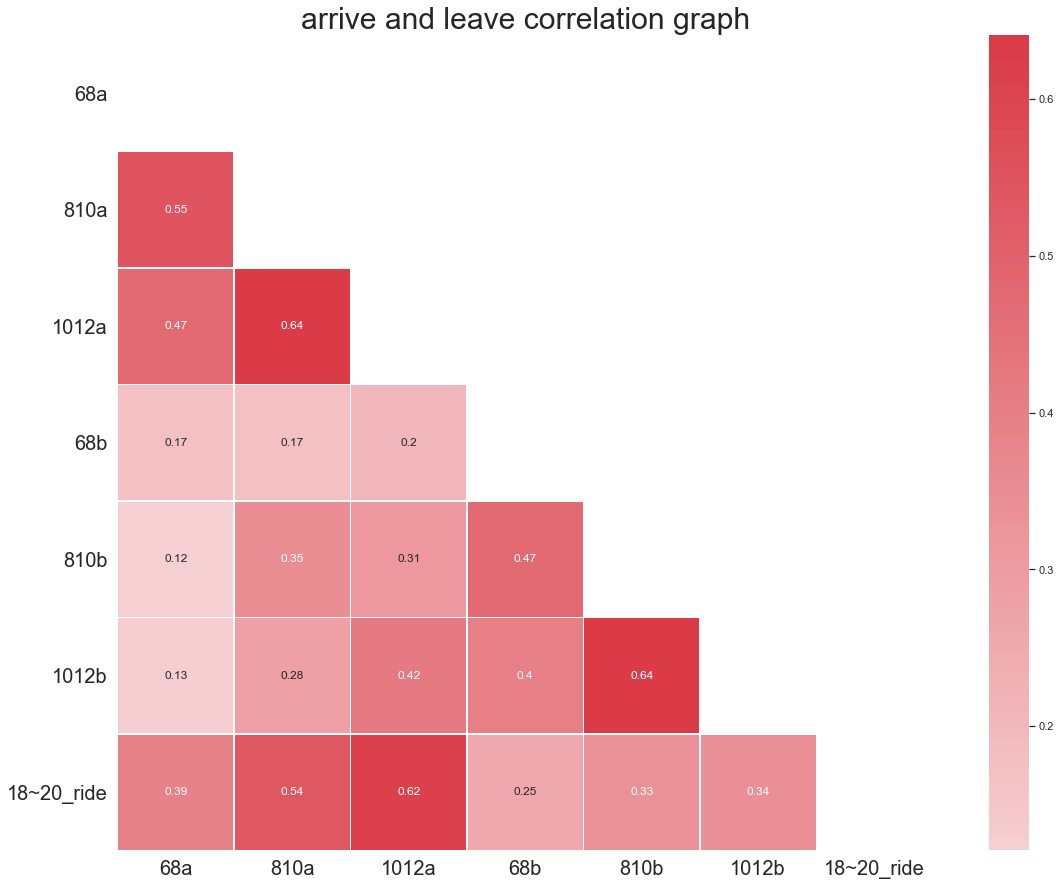

In [12]:
train22=train[['68a','810a','1012a','68b','810b','1012b','18~20_ride']]

cor=train22.corr()

sns.set(style="white")
mask=np.zeros_like(cor,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

f,ax=plt.subplots(figsize=(20,15))
cmap=sns.diverging_palette(200,10,as_cmap=True)
sns.heatmap(cor,mask=mask,cmap=cmap,center=0,square=True,linewidths=0.5,cbar_kws={"shrink":1},annot=True); #히트맵 생성
plt.xticks(size=20)
plt.yticks(size=20,rotation=0)
plt.title("arrive and leave correlation graph",size=30);

In [13]:
test['68a']=test['6~7_ride']+test['7~8_ride']
test['810a']=test['8~9_ride']+test['9~10_ride']
test['1012a']=test['10~11_ride']+test['11~12_ride']

test['68b']=test['6~7_takeoff']+test['7~8_takeoff']
test['810b']=test['8~9_takeoff']+test['9~10_takeoff']
test['1012b']=test['10~11_takeoff']+test['11~12_takeoff']

In [14]:
# 해당 주요 장소의 임의 지역 위도, 경도

jeju=(33.51411, 126.52969) # 제주 측정소 근처
gosan=(33.29382, 126.16283) #고산 측정소 근처
seongsan=(33.38677, 126.8802) #성산 측정소 근처
po=(33.24616, 126.5653) #서귀포 측정소 근처

#제주도 지역이 보일 수 있는 위치의 위도, 경도를 표시한 뒤, folium.Map에 변수로 넣고, map_osm에 할당
map_osm= folium.Map((33.399835, 126.506031),zoom_start=9)
mc = MarkerCluster()

mc.add_child( folium.Marker(location=jeju,popup='제주 측정소',icon=folium.Icon(color='red',icon='info-sign') ) ) #제주 측정소 마커 생성
map_osm.add_child(mc) #마커를 map_osm에 추가

mc.add_child( folium.Marker(location=gosan,popup='고산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=seongsan,popup='성산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=po,popup='서귀포 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc)

In [15]:
#정류장의 위치만 확인하기 위해 groupby를 실행함
data=train[['latitude','longitude','station_name']].drop_duplicates(keep='first')

data2=data.groupby(['station_name'])['latitude','longitude'].mean()

data2.to_csv("folium.csv")

data2=pd.read_csv("folium.csv")

#정류장의 대략적인 위치를 확인하기 위하여, folium map에 해당 정류장을 표시
for row in data2.itertuples():
    mc.add_child(folium.Marker(location=[row.latitude,  row.longitude], popup=row.station_name)) #마커 생성
    map_osm.add_child(mc) #마커를 map_osm에 추가
    
map_osm

In [16]:
t1 = [geopy.distance.geodesic( (i,j), jeju).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t2 = [geopy.distance.geodesic( (i,j), gosan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t3 = [geopy.distance.geodesic( (i,j), seongsan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t4 = [geopy.distance.geodesic( (i,j), po).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]

train['dis_jeju']=t1
train['dis_gosan']=t2
train['dis_seongsan']=t3
train['dis_po']=t4

In [17]:
total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
train['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

data22=train[['station_name','latitude','longitude','dist_name']].drop_duplicates(keep='first')

Counter(data22['dist_name'])

Counter({0: 1479, 3: 828, 1: 659, 2: 597})

In [18]:
t1 = [geopy.distance.geodesic( (i,j), jeju).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t2 = [geopy.distance.geodesic( (i,j), gosan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t3 = [geopy.distance.geodesic( (i,j), seongsan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t4 = [geopy.distance.geodesic( (i,j), po).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]

test['dis_jeju']=t1
test['dis_gosan']=t2
test['dis_seongsan']=t3
test['dis_po']=t4

total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
test['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

In [19]:
#데이터 불러오기
raining=pd.read_csv(r"C:\Users\gram\Desktop\prj 1\data13\rain.csv",engine='python')

#외부데이터에서 나오는 지점명들을 변경
raining['지점'] = [ str(i) for i in raining['지점'] ]

raining['지점'] = ['jeju' if i=='184' else i for i in raining['지점'] ]  # 위도 : 33.51411 경도 : 126.52969
raining['지점'] = ['gosan' if i=='185' else i for i in raining['지점'] ]  # 위도 : 33.29382 경도 : 126.16283
raining['지점'] = ['seongsan' if i=='188' else i for i in raining['지점'] ]  # 위도 : 33.38677 경도 : 126.8802
raining['지점'] = ['po' if i=='189' else i for i in raining['지점'] ]  # 위도 : 33.24616 경도 : 126.5653

raining.head()

,지점,지점명,일시,기온(°C),강수량(mm)
0,jeju,제주,2019-09-01 00:00,23.7,NaN
1,jeju,제주,2019-09-01 01:00,23.7,NaN
2,jeju,제주,2019-09-01 02:00,23.5,NaN
3,jeju,제주,2019-09-01 03:00,23.4,NaN
4,jeju,제주,2019-09-01 04:00,23.4,NaN


In [20]:
raining['time'] = [ int( i.split(' ')[1].split(':')[0] ) for i in raining['일시']] 

raining['일시'] = [ i.split(' ')[0] for i in raining['일시'] ] 

# 실제 측정 데이터이기 때문에, 12시 이전의 시간대만 사용
rain2 = raining[ (raining['time']>12)  ]

In [21]:
rain3 = rain2.groupby(['지점','일시'])[['기온(°C)','강수량(mm)']].mean()

rain3.to_csv("rain3.csv")

rain3=pd.read_csv("rain3.csv")

# train, test의 변수명과 통일시키고, NaN의 값은 0.0000으로 변경
rain3 = rain3.rename(columns={"일시":"date","지점":"dist_name"})
rain3= rain3.fillna(0.00000)

In [26]:
train = train.astype({'dist_name': 'object'})

In [29]:
test = test.astype({'dist_name': 'object'})

In [30]:
train2=pd.merge(train,rain3,how='left',on=['dist_name','date'])
test2=pd.merge(test,rain3,how='left',on=['dist_name','date'])

In [31]:
train2 = pd.get_dummies(train2,columns=['dist_name'])
test2 = pd.get_dummies(test2,columns=['dist_name'])

train2.shape, test2.shape, train.shape, test.shape

((415423, 44), (228170, 43), (415423, 39), (228170, 38))

In [32]:
input_var=['in_out','latitude', 'longitude', '68a', '810a', '1012a', '68b', '810b', '1012b',
           'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
           'dis_jeju', 'dis_gosan','dis_seongsan', 'dis_po','기온(°C)', '강수량(mm)', 
           'dist_name_1', 'dist_name_0','dist_name_3', 'dist_name_2']

target=['18~20_ride']

In [33]:
X_train=train2[input_var]
random.seed(1217) #동일한 샘플링하기 위한 시드번호
train_list=random.sample(list(range(X_train.shape[0])), int(round(X_train.shape[0]*0.01,0)) )

X_train=train2[input_var]
X_train=X_train.iloc[train_list,:]
y_train=train2[target]
y_train=y_train.iloc[train_list,:]

X_test=test2[input_var]

X_train.shape, y_train.shape

((4154, 26), (4154, 1))

In [34]:
X_train = np.nan_to_num(X_train)

In [35]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_features': [2,3,5],
    'min_samples_leaf': [2,3],
    'min_samples_split': [2,4,6],
    'n_estimators': [100, 200,500]
}
# Create a based model
rf = RandomForestRegressor(random_state=1217) # 랜덤포레스트 모델을 정의한다.
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid) # GridSearchCV를 정의한다.

grid_search.fit(X_train, y_train)

grid_search.best_params_ #학습 이후 최적의 paramter를 출력

#해당 코드 실행시간 2분 ~ 3분 소요

{'max_features': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 100}

In [37]:
#전체 데이터로 적용
X_train=train2[input_var]
y_train=train2[target]

X_test=test2[input_var]

X_train.shape, y_train.shape, X_test.shape

((415423, 26), (415423, 1), (228170, 26))

In [38]:
X_train = np.nan_to_num(X_train)

In [40]:
X_test = np.nan_to_num(X_test)

In [41]:
# best_params_를 통해서 나온 값을 투입
rf = RandomForestRegressor(max_features=5,min_samples_leaf=3,min_samples_split=2,n_estimators=100,random_state=1217)

rf.fit(X_train,y_train) #학습 

test['18~20_ride'] = rf.predict(X_test) #예측값 생성 후, test['18~20_ride']에 집어 넣는다.

test[['id','18~20_ride']].to_csv("dacon_base_middle2.csv",index=False) # id와 18~20_ride만 선택 후 csv 파일로 내보낸다

#해당 코드 소요 시간 5분

## 특성 중요도

In [58]:
# 특성 중요도
print("특성 중요도 : \n{}".format(rf.feature_importances_))

특성 중요도 : 
[0.00117339 0.04709391 0.04558577 0.07780397 0.17564761 0.2724528
 0.03550779 0.05478405 0.05872613 0.00547138 0.00471409 0.00410639
 0.00254562 0.00374924 0.00270164 0.00618974 0.04845657 0.04829651
 0.05032171 0.04750889 0.         0.         0.00028792 0.00555755
 0.0009083  0.00040903]


In [67]:
X_data = pd.DataFrame(np.concatenate([X_train, X_test], axis=0))

AttributeError: 'DataFrame' object has no attribute 'feature_names'

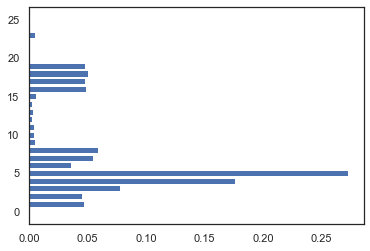

In [69]:
# 특성 중요도 시각화 하기
def plot_feature_importances_bus(model):
    n_features = X_data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_data.feature_names)
    plt.xlabel("attr importances")
    plt.ylabel("attr")
    plt.ylim(-1, n_features)
plt.show()

plot_feature_importances_bus(rf)

In [42]:
X_train_df = pd.DataFrame(X_train)

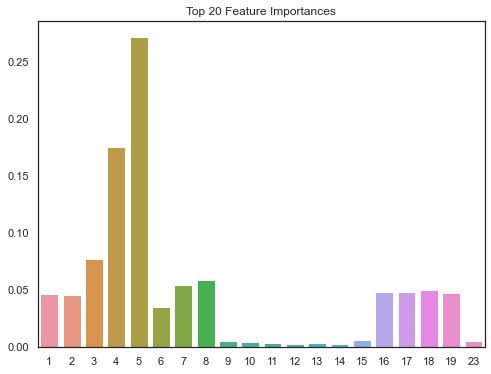

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train_df.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Top 20 Feature Importances')
sns.barplot(y=ftr_top20, x=ftr_top20.index)
plt.show()

In [44]:
ftr_top20

5     0.272453
4     0.175648
3     0.077804
8     0.058726
7     0.054784
18    0.050322
16    0.048457
17    0.048297
19    0.047509
1     0.047094
2     0.045586
6     0.035508
15    0.006190
23    0.005558
9     0.005471
10    0.004714
11    0.004106
13    0.003749
14    0.002702
12    0.002546
dtype: float64

In [45]:
ftr_top20.index = X_train_df.columns[ftr_top20.index]

In [46]:
ftr_top20.index

Int64Index([5, 4, 3, 8, 7, 18, 16, 17, 19, 1, 2, 6, 15, 23, 9, 10, 11, 13, 14,
            12],
           dtype='int64')

## 결정 트리 그래프

In [89]:
estimator = rf.estimators_[0]

export_graphviz(estimator, out_file='tree.dot', 
                feature_names = input_var,
                class_names = target,
                max_depth = 3, # 표현하고 싶은 최대 depth
                precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True, # 박스의 모양을 둥글게
               )

In [88]:
from sklearn.tree import export_graphviz
from graphviz import Source
Source.from_file("tree.dot")

ExecutableNotFound: failed to execute ['dot', '-Kdot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

## Auto ML

In [47]:
!pip install pycaret

ERROR: Could not install packages due to an EnvironmentError: [WinError 5] 액세스가 거부되었습니다: 'C:\\Users\\gram\\anaconda3\\Lib\\site-packages\\~klearn\\decomposition\\_cdnmf_fast.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.




  Using cached smart_open-4.1.0.tar.gz (116 kB)
INFO: pip is looking at multiple versions of pynndescent to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of umap-learn to determine which version is compatible with other requirements. This could take a while.
  Created wheel for cufflinks: filename=cufflinks-0.17.3-py3-none-any.whl size=68729 sha256=0b073e240157338088fd1b0478d441bb7620901b5ba01eb52b47497a72bd3b64
  Stored in directory: c:\users\gram\appdata\local\pip\cache\wheels\6b\76\62\6da97734911ffcbdd559fd1a3f28526321f0ae699182a23866
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27090 sha256=90a70d2d10294828c59ebf7ad97a5168b6a884a4c7738ee72992684c38705562
  Stored in directory: c:\users\gram\appdata\local\pip\cache\wheels\23\14\6e\4be5bfeeb027f4939a01764b48edd5996acf574b0913fe5243
  Created wheel for phik: filename=phik-0.11.0-py3-none-any.whl size=599743 sha256=8123ac3

In [48]:
from pycaret.classification import *
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings(action='ignore')

PATH = 'C:\Users\gram\Desktop\prj 1\중급'

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-48-31b7fa07b466>, line 16)

In [ ]:
train_err  = pd.read_csv(PATH+'train_err_data.csv')
id_error = train_err[['user_id','errtype']].values
error = np.zeros((15000,42))
for person_idx, err in tqdm(id_error):
    # person_idx - 10000 위치에 person_idx, errtype에 해당하는 error값을 +1
    error[person_idx - 10000,err - 1] += 1

train_prob = pd.read_csv(PATH+'train_problem_data.csv')
problem = np.zeros(15000)
problem[train_prob.user_id.unique()-10000] = 1 

train = pd.DataFrame(data=error)
train['problem'] = problem
del error, problem

clf = setup(data = train, target = 'problem') 

In [ ]:
best_5 = compare_models(sort = 'Accuracy', n_select = 5)

In [ ]:
blended = blend_models(estimator_list = best_5, fold = 5, method = 'soft')

In [ ]:
pred_holdout = predict_model(blended)

In [ ]:
final_model = finalize_model(blended)

In [ ]:
test_err  = pd.read_csv(PATH+'test_err_data.csv')
id_error = test_err[['user_id','errtype']].values
test_x = np.zeros((14999,42))
for person_idx, err in tqdm(id_error):
    test_x[person_idx - 30000,err - 1] += 1
test_x = test_x.reshape(test_x.shape[0],-1)
test = pd.DataFrame(data=test_x)

In [ ]:
predictions = predict_model(final_model, data = test)

In [ ]:
#pycaret에서는 score이 label을 맞출 확률이기때문에 output을 제출 양식에 맞게 바꿔줍니다
x = []
for i in range(len(predictions['Score'])):
    if predictions['Label'][i] =='1.0':
        x.append(predictions['Score'][i])
    else:
        x.append(1-predictions['Score'][i])

In [ ]:
sample_submssion = pd.read_csv(PATH+'sample_submission.csv')
sample_submssion['problem'] = x
sample_submssion.to_csv("AutoML.csv", index = False)